### Imports

In [ ]:
%pip install transformer_lens huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.0
    Uninstalling typeguard-4.4.0:
      Successfully uninstalled typeguard-4.4.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resol

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint
from typing import Dict, List, Optional, Tuple, Union
import numpy as np
from dataclasses import dataclass
from tqdm.auto import tqdm
import requests
import zipfile
import os
import json
from pathlib import Path
from functools import partial
import copy
import matplotlib.pyplot as plt

from huggingface_hub import login
login()

## Probing

#### Loading datasets

In [ ]:
# Label mappings
LABEL_MAPS = {
    "age": {
        "child": 0,
        "adolescent": 1,
        "adult": 2,
        "older adult": 3,
    },
    "gender": {
        "male": 0,
        "female": 1,
    },
    "socioeconomic": {
        "low": 0,
        "middle": 1,
        "high": 2
    },
    "education": {
        "someschool": 0,
        "highschool": 1,
        "collegemore": 2
    }
}

In [ ]:
DATA_MAPS = {
    "age": 2,
    "gender": 4,
    "socioeconomic": 2,
    "education": 3
}

In [ ]:
def parse_chat_string(chat_string):
    """
    Parse a chat string into a list of dictionaries with alternating roles.
    Handles cases where '### Role:' appears within message content.

    Args:
        chat_string (str): The input chat string

    Returns:
        list: List of dictionaries with 'role' and 'content' keys
    """

    result = []

    # Split on actual message boundaries while preserving the "### "
    parts = chat_string.split('### ')

    for part in parts:
        if not part.strip():
            continue

        if not (part.startswith('Human:') or part.startswith('Assistant:')):
            # This is content that should be part of the previous message
            if result:
                result[-1]['content'] += '### ' + part
            continue

        role, content = part.split(':', 1)
        role = role.lower().replace('human', 'user')

        # If we already have a message with this role, merge the content
        if result and result[-1]['role'] == role:
            result[-1]['content'] += '\n\n' + content.strip()
        else:
            # New message with different role
            result.append({
                'role': role,
                'content': content.strip()
            })

    if result[0]['role'] == 'assistant':
        result = result[1:]

    return result

In [ ]:
def load_dataset(
    attribute: str,
    control_probe: bool = False
) -> Tuple[List[str], List[int]]:
    """Load dataset for a given attribute"""

    texts = []
    labels = []
    label_map = LABEL_MAPS[attribute]

    if attribute == "education":
        data_paths = [Path(f"dataset/openai_{attribute}_three_classes_{i}.zip") for i in range(1, DATA_MAPS[attribute]+1)]
    else:
        data_paths = [Path(f"dataset/openai_{attribute}_{i}.zip") for i in range(1, DATA_MAPS[attribute]+1)]


    for data_path in data_paths:
        if not data_path.exists():
            print("Downloading dataset...")
            url = f"https://github.com/yc015/TalkTuner-chatbot-llm-dashboard/raw/main/data/dataset/{data_path.name}"
            response = requests.get(url)
            if response.status_code != 200:
                raise ValueError(f"Download failed: HTTP {response.status_code}")

            data_path.parent.mkdir(parents=True, exist_ok=True)
            with open(data_path, "wb") as f:
                f.write(response.content)

        # Extract if needed
        extract_path = data_path.parent / data_path.stem

        if not extract_path.exists():
            print("Extracting files...")
            with zipfile.ZipFile(data_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)

        # Process txt files
        for txt_file in extract_path.glob("*.txt"):
            # Extract label from filename (e.g., "conversation_107_age_adolescent.txt" -> "adolescent")
            label = txt_file.stem.split('_')[-1]

            if label in label_map:
                with open(txt_file) as f:
                    text = f.read().strip()

                if text.rfind("\n\n### Assistant:") > text.rfind("\n\n### Human:"):
                    text = text[:text.rfind("\n\n### Assistant:")]

                if not control_probe:
                    text += f"\n\n### Assistant: I think the {attribute} of this user is"

                chat_history = parse_chat_string(text)
                if chat_history and isinstance(chat_history, (list, tuple)):
                  texts.append(model.tokenizer.apply_chat_template(chat_history, tokenize=False, add_generation_prompt=True))
                  labels.append(label_map[label])

    return texts, labels

#### Defining probes

In [ ]:
class LinearProbes(nn.Module):
    def __init__(self, input_dim: int, num_classes: int):
        super().__init__()
        self.probe = nn.Linear(input_dim, num_classes)

        nn.init.xavier_uniform_(self.probe.weight)
        nn.init.zeros_(self.probe.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid(self.probe(x.to(dtype=torch.float)))

    def get_grouped_params(self):
        decay = []
        no_decay = []

        for name, param in self.named_parameters():
            if not param.requires_grad:
                continue
            if 'bias' in name:
                no_decay.append(param)
            else:
                decay.append(param)

        return [
            {'params': decay},
            {'params': no_decay, 'weight_decay': 0.0}
        ]


In [ ]:
@dataclass
class ProbeConfig:
    """Configuration for probe training"""
    learning_rate: float = 1e-3
    betas: Tuple[float, float] = (0.9, 0.95)
    weight_decay: float = 0.1
    batch_size: int = 200
    num_epochs: int = 50
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

#### Getting activations

In [ ]:
class ProbeDataset(Dataset):
    def __init__(self, model: HookedTransformer, texts: List[str], labels: List[int], num_classes: int, batch_size: int):
        self.model = model
        self.labels = torch.tensor(labels)
        self.num_classes = num_classes
        self.len = len(texts)
        self.batch_size = batch_size
        self.text_loader = DataLoader(texts, batch_size=batch_size, shuffle=False)

        self.activations = self._get_activations(texts)

    def _get_activations(self, texts: List[str]) -> List[torch.Tensor]:

        activations = [[] for _ in range(self.model.cfg.n_layers)]

        def hook_fn(resid: torch.Tensor, hook: HookPoint, layer: int, posns: torch.Tensor) -> torch.Tensor:
            activations[layer].append(resid[torch.arange(resid.shape[0]), posns, :].clone().to('cpu'))
            return resid


        for batch in tqdm(self.text_loader):

            tokens = self.model.to_tokens(batch, prepend_bos=True, padding_side='right')
            final_posns = (tokens.clone().to('cpu') != self.model.tokenizer.pad_token_id).sum(dim=-1) - 1

            with torch.no_grad():
                self.model.run_with_hooks(tokens,
                                          fwd_hooks=[(f'blocks.{layer}.hook_resid_post', partial(hook_fn, layer=layer, posns = final_posns)) for layer in range(self.model.cfg.n_layers)],
                                          return_type=None)


        for layer in range(self.model.cfg.n_layers):

            activations[layer] = torch.cat(activations[layer], dim=0)

        # shape: [n_layers, n_dataset, d_model]
        return torch.stack(activations)



    def __len__(self) -> int:
        return self.len

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        activation = self.activations[:,idx]
        label = torch.zeros(self.num_classes)
        label[self.labels[idx]] = 1.0
        return activation, label

#### Training probes

In [ ]:
def train_eval_probe(
    model: HookedTransformer,
    probe: LinearProbes,
    train_loader: DataLoader,
    eval_loader: DataLoader,
    test_loader: DataLoader,
    layer: int,
    config: ProbeConfig) :

    probe = probe.to(config.device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.AdamW(probe.get_grouped_params(),
                                  lr=config.learning_rate,
                                  betas=config.betas,
                                  weight_decay=config.weight_decay,
    )

    losses = []
    accuracies = []
    best_accuracy = 0
    best_probe = None

    for epoch in range(config.num_epochs):
        epoch_losses = []
        for activs, labels in train_loader:
            probe.train()
            activations = activs[:,layer].to(config.device)
            labels = labels.to(config.device)

            optimizer.zero_grad()
            outputs = probe(activations)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)

        # Eval and store top
        with torch.no_grad():
            probe.eval()
            eval_total_correct = 0
            eval_total_samples = 0
            for activs, labels in eval_loader:
                activations = activs[:,layer].to(config.device)
                labels = labels.to(config.device)

                outputs = probe(activations)
                predictions = outputs.argmax(dim=-1)
                true_labels = labels.argmax(dim=-1)

                eval_total_correct += (predictions == true_labels).sum().item()
                eval_total_samples += labels.size(0)

            accuracies.append(eval_total_correct / eval_total_samples)
            if accuracies[-1] > best_accuracy:
                best_accuracy = accuracies[-1]
                best_probe = copy.deepcopy(probe)


    test_total_correct = 0
    test_total_samples = 0
    for activs, labels in test_loader:
        activations = activs[:,layer].to(config.device)
        labels = labels.to(config.device)

        outputs = best_probe(activations)
        predictions = outputs.argmax(dim=-1)
        true_labels = labels.argmax(dim=-1)

        test_total_correct += (predictions == true_labels).sum().item()
        test_total_samples += labels.size(0)

    test_accuracy = test_total_correct / test_total_samples

    return best_probe, losses, accuracies, test_accuracy

#### Example

In [ ]:
model = HookedTransformer.from_pretrained("gemma-2-9b-it", device='cpu', dtype=torch.bfloat16)
model.to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model gemma-2-9b-it into HookedTransformer
Moving model to device:  cuda


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-41): 42 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln1_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (

In [ ]:
## Don't rerun
all_probe_test_accuracies = {}
all_probe_eval_accuracies = {}

In [ ]:
dataset_name = 'education'
control_probe = False

texts, labels = load_dataset(dataset_name, control_probe)
num_classes = len(LABEL_MAPS[dataset_name])
config = ProbeConfig(batch_size=64)

probe_data = ProbeDataset(model, texts, labels, num_classes, batch_size=5)

## I might want to centre these activations here

train_size = int(0.7 * len(probe_data))
eval_size = int(0.2 * len(probe_data))
test_size = len(probe_data) - train_size - eval_size

train_dataset, eval_dataset, test_dataset = random_split(probe_data, [train_size, eval_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=config.batch_size)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size)

Extracting files...
Extracting files...
Extracting files...


  0%|          | 0/895 [00:00<?, ?it/s]

In [ ]:
eval_accuracies = []
test_accuracies = []
all_probes = []
for layer in tqdm(range(model.cfg.n_layers), desc="Probing layers"):

    probe = LinearProbes(model.cfg.d_model, num_classes)
    trained_probe, losses, accuracy, test_accuracy = train_eval_probe(model, probe, train_loader, eval_loader, test_loader, layer, config)

    eval_accuracies.append(max(accuracy))
    test_accuracies.append(test_accuracy)
    all_probes.append(trained_probe)

Probing layers:   0%|          | 0/42 [00:00<?, ?it/s]

In [ ]:
layer = 37

probe = LinearProbes(model.cfg.d_model, num_classes)
trained_probe, losses, accuracy, test_accuracy = train_eval_probe(model, probe, train_loader, eval_loader, test_loader, layer, config)

eval_accuracies[layer] = (max(accuracy))
test_accuracies[layer] = (test_accuracy)
all_probes[layer] = (trained_probe)

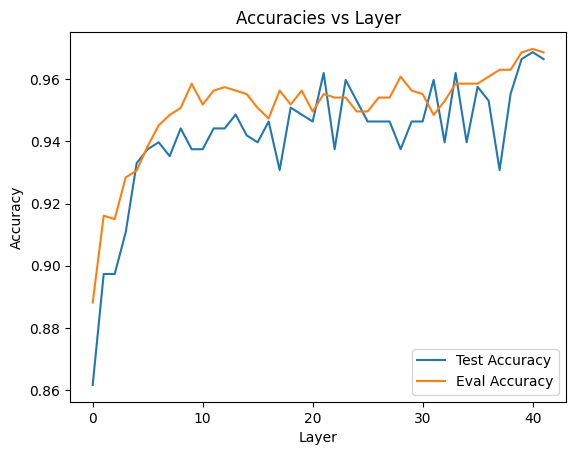

In [ ]:
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(eval_accuracies, label='Eval Accuracy')
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title('Accuracies vs Layer')
plt.legend()
plt.show()

In [ ]:
collected_probe_weights = torch.empty(0, num_classes, model.cfg.d_model)
collected_probe_bias = torch.empty(0, num_classes)
for probe in all_probes:
    collected_probe_weights = torch.cat((collected_probe_weights, probe.probe.weight[None, :, :].cpu()), 0)
    collected_probe_bias = torch.cat((collected_probe_bias, probe.probe.bias[None, :].cpu()), 0)

torch.save(collected_probe_weights, f"collected_{dataset_name}_probe_weights.pt")
torch.save(collected_probe_bias, f"collected_{dataset_name}_probe_biases.pt")

collected_probe_weights.shape, collected_probe_bias.shape

(torch.Size([42, 3, 3584]), torch.Size([42, 3]))

In [ ]:
all_probe_test_accuracies[dataset_name] = test_accuracies
all_probe_eval_accuracies[dataset_name] = eval_accuracies

In [ ]:
import json

with open('all_probe_test_accuracies.json', 'w') as f:
    json.dump(all_probe_test_accuracies, f)

with open('all_probe_eval_accuracies.json', 'w') as f:
    json.dump(all_probe_eval_accuracies, f)